In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import sys
import matplotlib
import numpy
import functools
import os
if 'DISPLAY' not in os.environ:
    matplotlib.use('Agg')
    show_image=False
else:
    show_image=True
from matplotlib import pyplot as plt
from torchvision import utils
from skimage import io, transform
from torchvision.transforms import ToPILImage
from torch.utils.data import Dataset, DataLoader
from torch.nn import init

In [2]:
def sinkhorn_loss(x, y, epsilon, n, niter):
    """
	Given two emprical measures with n points each with locations x and y
	outputs an approximation of the OT cost with regularization parameter epsilon
	niter is the max. number of steps in sinkhorn loop
	"""
    # The Sinkhorn algorithm takes as input three variables :
    C = cost_matrix(x, y)  # Wasserstein cost function

    # both marginals are fixed with equal weights
    if use_cuda:
        mu = Variable(
            1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
        nu = Variable(
            1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
    else:
        mu = Variable(
            1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)
        nu = Variable(
            1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)

    # Parameters of the Sinkhorn algorithm.
    rho = 1  #(.5) **2          # unbalanced transport
    tau = -.8  # nesterov-like acceleration
    lam = rho / (rho + epsilon)  # Update exponent
    thresh = 10**(-1)  # stopping criterion

    # Elementary operations .....................................................................
    def ave(u, u1):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

    def M(u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(1) + v.unsqueeze(0)) / epsilon

    def lse(A):
        "log-sum-exp"
        return torch.log(torch.exp(A).sum(1, keepdim=True) +
                         1e-6)  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * mu, 0. * nu, 0.
    actual_nits = 0  # to check if algorithm terminates because of threshold or max iterations reached

    for i in range(niter):
        u1 = u  # useful to check the update
        u = epsilon * (torch.log(mu) - lse(M(u, v)).squeeze()) + u
        v = epsilon * (torch.log(nu) - lse(M(u, v).t()).squeeze()) + v
        # accelerated unbalanced iterations
        #u = ave( u, lam * ( epsilon * ( torch.log(mu.unsqueeze(1)) - lse(M(u,v))   ) + u ) )
        #v = ave( v, lam * ( epsilon * ( torch.log(nu.unsqueeze(1)) - lse(M(u,v).t()) ) + v ) )
        err = (u - u1).abs().sum()

        actual_nits += 1
        if (err < thresh).data.cpu().numpy():
            break
    U, V = u, v
    pi = torch.exp(M(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    cost = torch.sum(pi * C)  # Sinkhorn cost
    print(pi)

    return cost


def cost_matrix(x, y, p=2):
    "Returns the matrix of $|x_i-y_j|^p$."
    x_col = x.unsqueeze(1)
    y_lin = y.unsqueeze(0)
    c = torch.sum((torch.abs(x_col - y_lin))**p, 2)
    return c

In [3]:
class Edges2ShoesDataset(Dataset):
    """Edge to shoes dataset"""

    def __init__(self, root_dir, transform):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return 49825

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, 'train/%d_AB.jpg'%(idx+1))
        image = io.imread(img_name)
        sample=self.transform(image)
        A=sample[:,:,:256]
        B=sample[:,:,256:]
        return [A,B]

In [4]:
def imshow(inp, file_name, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(10, 20))
    inp = transforms.ToPILImage()(inp)
    plt.imshow(inp,cmap='gray')
    plt.savefig(file_name)
    if show_image:
        plt.show()
    else:
        plt.gcf().clear()

In [5]:
batch_size = 10
z_size=2
hidden_size=64
img_size=256
niter=100
epsilon=0.1
G_lr = D_lr = 5e-3
use_cuda=torch.cuda.is_available()

In [6]:
root = '/Users/sunxiaofei/Downloads/edges2shoes/'
download = True
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
data_set = Edges2ShoesDataset(root_dir=root, transform=trans)
kwargs = {}
D_loader = torch.utils.data.DataLoader(
    dataset=data_set, batch_size=batch_size, shuffle=True)
G_loader = torch.utils.data.DataLoader(
    dataset=data_set, batch_size=batch_size, shuffle=True)

In [7]:
class UnetGenerator(nn.Module):
    def __init__(self,
                 input_nc,
                 output_nc,
                 num_downs,
                 ngf=64,
                 norm_layer=nn.BatchNorm2d,
                 use_dropout=False,
                 gpu_ids=[]):
        super(UnetGenerator, self).__init__()
        self.gpu_ids = gpu_ids

        # construct unet structure
        unet_block = UnetSkipConnectionBlock(
            ngf * 8,
            ngf * 8,
            input_nc=None,
            submodule=None,
            norm_layer=norm_layer,
            innermost=True)
        for i in range(num_downs - 5):
            unet_block = UnetSkipConnectionBlock(
                ngf * 8,
                ngf * 8,
                input_nc=None,
                submodule=unet_block,
                norm_layer=norm_layer,
                use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(
            ngf * 4,
            ngf * 8,
            input_nc=None,
            submodule=unet_block,
            norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(
            ngf * 2,
            ngf * 4,
            input_nc=None,
            submodule=unet_block,
            norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(
            ngf,
            ngf * 2,
            input_nc=None,
            submodule=unet_block,
            norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(
            output_nc,
            ngf,
            input_nc=input_nc,
            submodule=unet_block,
            outermost=True,
            norm_layer=norm_layer)

        self.model = unet_block

    def forward(self, input):
        if self.gpu_ids and isinstance(input.data, torch.cuda.FloatTensor):
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)


# Defines the submodule with skip connection.
# X -------------------identity---------------------- X
#   |-- downsampling -- |submodule| -- upsampling --|
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self,
                 outer_nc,
                 inner_nc,
                 input_nc=None,
                 submodule=None,
                 outermost=False,
                 innermost=False,
                 norm_layer=nn.BatchNorm2d,
                 use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(
            input_nc,
            inner_nc,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(
                inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(
                inner_nc,
                outer_nc,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(
                inner_nc * 2,
                outer_nc,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [9]:
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False, gpu_ids=[]):
        super(NLayerDiscriminator, self).__init__()
        self.gpu_ids = gpu_ids
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 100, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        if len(self.gpu_ids) and isinstance(input.data, torch.cuda.FloatTensor):
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main=nn.Sequential(
            nn.Linear(100,100)
        )

    def forward(self, x):
        x = x.view(x.size(0), 3*img_size * img_size)
        return x

In [11]:
one = torch.FloatTensor([1])
noise_holder=torch.FloatTensor(batch_size, z_size, 1, 1)
input_holder = torch.FloatTensor(batch_size, 1, img_size, img_size)
if use_cuda:
    one=one.cuda()
    noise_holder=noise_holder.cuda()
    input_holder=input_holder.cuda()
mone = one * -1

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
def weights_init_normal(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.uniform(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.uniform(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        init.uniform(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)


In [13]:
data=iter(G_loader).next()

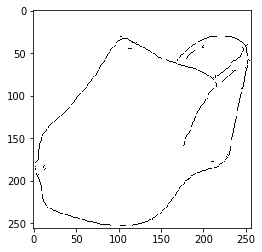

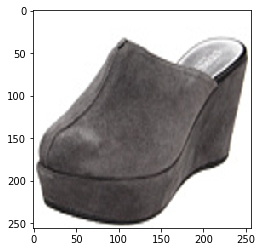

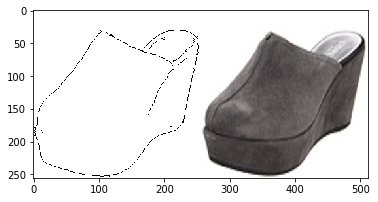

In [14]:
d1=data[0][0].mul(0.5).add(0.5)
plt.imshow(ToPILImage()(d1))
plt.show()
d2=data[1][0].mul(0.5).add(0.5)
plt.imshow(ToPILImage()(d2))
plt.show()
d3=torch.cat((data[0],data[1]),3)[0].mul(0.5).add(0.5)
plt.imshow(ToPILImage()(d3))
plt.show()

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,hidden_size,4,2,1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(True),
            nn.Conv2d(hidden_size,hidden_size*2,4,2,1),
            nn.BatchNorm2d(hidden_size*2),
            nn.ReLU(True),
            nn.Conv2d(hidden_size*2,hidden_size*4,4,2,1),
            nn.BatchNorm2d(hidden_size*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(hidden_size*4,hidden_size*2,4,2,1),
            nn.BatchNorm2d(hidden_size*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size*2,hidden_size,4,2,1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size,3,4,2,1),
            nn.BatchNorm2d(3),
        )
    def forward(self, x):
        x = x.view(x.size()[0], 3, img_size, img_size)
        print(x.size())
        out = self.model(x)
        print(out.size())
        out = out.view(x.size()[0], 3, img_size,img_size)
        return out

In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            # 1*3
            nn.Conv2d(6,hidden_size,4,2,1),
            nn.BatchNorm2d(hidden_size),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(hidden_size,hidden_size*2,4,2,1),
            nn.BatchNorm2d(hidden_size*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(hidden_size*2,hidden_size*4,4,2,1),
            nn.BatchNorm2d(hidden_size*4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(hidden_size*4,hidden_size*8,4,2,1),
        )
        self.linear=nn.Sequential(
            nn.Linear(hidden_size*8*16*16,100),
            nn.Tanh(),
        )
    def forward(self, x):
        out = self.model(x.view(x.size(0), 6, img_size, img_size))
        out=out.view(x.size()[0],hidden_size*8*16*16)
        out=self.linear(out)
        out = out.view(-1,100)
        return out

In [28]:
data=next(iter(G_loader))

In [29]:
G= Generator()

In [30]:
A,B=data
A=Variable(A)
B=Variable(B)
fake_B=G(A)

torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])


In [31]:
D = Discriminator()

In [32]:
real_AB=torch.cat((A,B),1)

In [33]:
real_AB.size()

torch.Size([10, 6, 256, 256])

In [34]:
y=D(real_AB)

In [35]:
y.size()

torch.Size([10, 100])

In [38]:
from tqdm import tqdm
G= UnetGenerator(3, 3, 8)
init_weights(G)
D = Discriminator()
# D=NLayerDiscriminator(input_nc=3)
# print(G)
if use_cuda:
    G.cuda()
    D.cuda()
optimizers = {
    'D': torch.optim.RMSprop(D.parameters(), lr=D_lr),
    'G': torch.optim.RMSprop(G.parameters(), lr=G_lr)
}
criterion = nn.BCELoss()
errs=[]
for epoch in tqdm(range(10000)):
    for p in D.parameters():
        p.requires_grad = True
    for p in G.parameters():
        p.requires_grad = False
    if epoch<25 or epoch%100==0:
        iter_D=1
    else:
        iter_D=1
    for _ in range(iter_D):
        optimizers['D'].zero_grad()
        A,B=next(iter(D_loader))
        if use_cuda:
            A=A.cuda()
            B=B.cuda()
        A=Variable(A)
        B=Variable(B)
        fake_data = G(A)
        real_AB=torch.cat((A,B),3)
        fake_AB=torch.cat((A,fake_data),3)
        y = D(real_AB)
        x = D(fake_AB)
        W_xy=sinkhorn_loss(x,y,epsilon,100,niter)
        W_xx=sinkhorn_loss(x,x,epsilon,100,niter)
        W_yy=sinkhorn_loss(y,y,epsilon,100,niter)
        Loss_D=2*W_xy-W_xx-W_yy
        Loss_D.backward(mone)
        optimizers['D'].step()
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)
        
    for p in D.parameters():
        p.requires_grad = False    
    for p in G.parameters():
        p.requires_grad = True
    optimizers['G'].zero_grad()
    A,B=next(iter(G_loader))
    if use_cuda:
        A=A.cuda()
        B=B.cuda()
    A=Variable(A)
    B=Variable(B)
    fake_data = G(A)
    real_AB=torch.cat((A,B),3)
    fake_AB=torch.cat((A,fake_data),3)
    y = D(real_AB)
    x = D(fake_AB)
    W_xy=sinkhorn_loss(x,y,epsilon,100,niter)
    W_xx=sinkhorn_loss(x,x,epsilon,100,niter)
    W_yy=sinkhorn_loss(y,y,epsilon,100,niter)
    Loss_G=2*W_xy-W_xx-W_yy
    Loss_G.backward(one)
    if use_cuda:
        errs.append(Loss_G.cpu().data[0])
    else:
        errs.append(Loss_G.data[0])
    optimizers['G'].step()

    if epoch % 1 == 0:
        to_show=torch.cat((fake_AB,B),3)
        if use_cuda:
            dd = utils.make_grid(to_show.cpu().data[:10], nrow=1)
        else:
            dd = utils.make_grid(to_show.data[:10],nrow=1)
        dd = dd.mul(0.5).add(0.5)
        vutils.save_image(dd, './results/Vuil_Sinkhorn_DC_%d.png'%(epoch))
        imshow(dd,'./results/Sinkhorn_DC_%d.png'%(epoch))
        plt.plot(errs)
        plt.savefig('./results/Sinkhorn_DC_loss.png')

initialization method [normal]


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/sunxiaofei/anaconda3/lib/python3.6/site-packages/torch/autograd/_functions/basic_ops.py:17: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return a.add(b)



RuntimeError: inconsistent tensor size, expected r_ [100], t [100] and src [10] to have the same number of elements, but got 100, 100 and 10 elements respectively at /Users/soumith/miniconda2/conda-bld/pytorch_1503975723910/work/torch/lib/TH/generic/THTensorMath.c:887